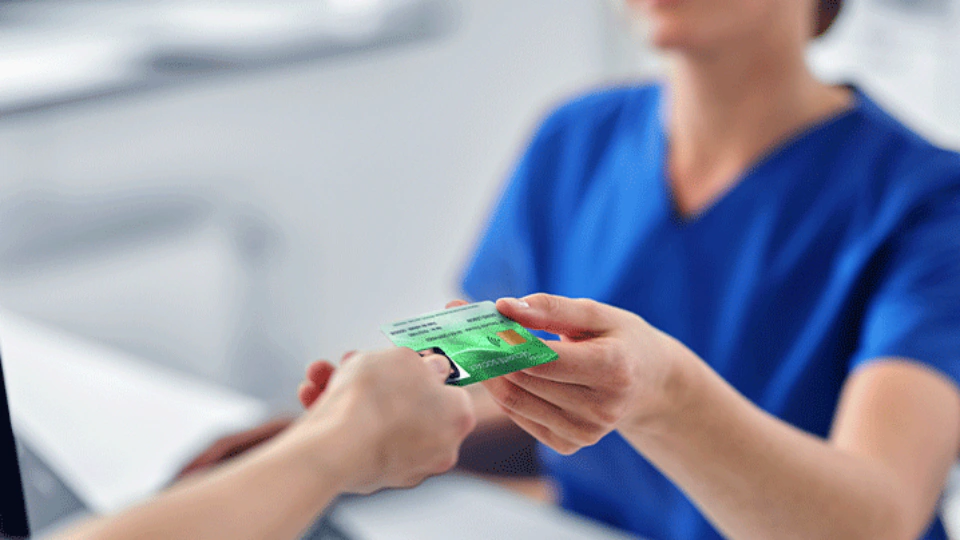

# U.S. Medical Insurance Costs

## Introduction

This project explores issues within a provided dataset on US healthcare insurance costs. The data is supplied is a CSV format, and to give an indicative view of what this data looks like, the first 10 entries in the CSV file are shown below:

In [48]:
# Set up libraries, import csv, and print first 5 rows
import csv # Not used much here - more to test a particular coding challenge, but creates a much more verbose solution than using Pandas
import numpy as np
import pandas as pd
import seaborn as sns
import os

with open("insurance.csv") as insurance_csv_file:
  pd_df = pd.read_csv(insurance_csv_file)
pd_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


There are 1338 subjects in the dataset.

## Scope

The aims of the project are to explore the charges in healthcare insurance in the the US, and particularly for the differences in charges:

 - Frequency of region of people (important for testing the validity of data - are there representative proportions drawn from all areas?)
 - How does the cost of insurance vary between men and women?
 - If there is a difference, what correlations can be found in the data that may be connected to these differences?
 - Two-way table between male and female, and smoking and non-smoking, with a Chi squared analysis to test whether there is statistical significance
 - Is there a difference in ages between areas?
 - Is there a relationship between average cost of insurance, and area lived in?  How does this vary between men and women? (Chi squared)


### Are there broadly similar numbers of records drawn from the four quadrants of the US?

Whilst, of course, this might not necessarily reflect the fact that there aren't similar numbers in the parent population (that is, the sample wasn't stratified by area), it is important to ensure there are sufficient numbers to ensure reliability in the data.

In [49]:
# Manual calculation of regions frequency table - VERBOSE WAY OF DOING THIS! It's shorter and more efficient to use Pandas, as is dome after this

region_list = []
region_count = {}

with open("insurance.csv") as insurance_csv_file:
    insurance_csv = list(csv.reader(insurance_csv_file)) # Opening csv file using CSV library (rather than Pandas)


for person in insurance_csv:
    region_list.append(person[5]) # Creates new region list with all entries in it as single entries
      
for item in region_list:
    if item not in region_count:
        region_count[item] = region_list.count(item) # Creates new dictionary with a pair of item key, and value being the count of that item 

del region_count["region"] # Deletes first title row

print(region_count) # Outputs counts
total = len(region_list)

for value in region_count.values():
    print(str(round((value/total*100), 1)) + "%")
    

{'southwest': 325, 'southeast': 364, 'northwest': 325, 'northeast': 324}
24.3%
27.2%
24.3%
24.2%


In [50]:
# Region frequency table from Pandas object - used to demonstrate a much more efficient way of achieving the above cell!

pd_df["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [51]:
pd_df["region"].value_counts(normalize=True) # Percentages of area representation (or at least dec equiv of percentages)

region
southeast    0.272048
southwest    0.242900
northwest    0.242900
northeast    0.242152
Name: proportion, dtype: float64

From these three cells, it can be seen that there are broadly similar numbers of data drawn from these areas of the US.

### What ages of people are represented in the data?

In [52]:
# Grouped freq table on age
bins = [0,10,20,30,40,50,60,70,80,90]
labels = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99"]
pd_df["age_freq"] = pd.cut(pd_df["age"], bins, labels) # Adds additional column with group
pd_df["age_freq"].value_counts(sort=False) # Creates freq table to show distribution



age_freq
(0, 10]       0
(10, 20]    166
(20, 30]    278
(30, 40]    257
(40, 50]    281
(50, 60]    265
(60, 70]     91
(70, 80]      0
(80, 90]      0
Name: count, dtype: int64

It is of note, particularly to someone from outside the US (as the author of this document is) that there is no one in the data in the 70-79 group or older.

In [53]:
max_age = max(pd_df["age"])
print("The oldest person in the dataset is " + str(max_age) + " years old.")

The oldest person in the dataset is 64 years old.


### Children, age, and insurance costs

Do older people pay more for insurance?  Do people with children pay more for insurance?  And is having children a proxy for age?

However, first, we need to consider whether we should use mean or median, and this is influenced by whether there are outliers in the "charges" data.  If there are outliers in the data, we will consider median as a measure of central tendency, rather than mean.  The commonly-used test for outliers is if there are values (at the upper end - the same would be true at the lower end, but we need not consider that here) in the data that exceed the threshold value of 1.5*IQR + Upper Quartile.

In [54]:
q75, q25 = np.percentile(pd_df["charges"], [75 ,25])
iqr = q75 - q25
upper_outlier_value = (1.5*iqr + q75).round(2)

max_charges = max(pd_df["charges"])

print("The threshold value to use as a test for outliers is " + str(upper_outlier_value) + ". If there are values that exceed this, they would be \
outliers, and we should therefore use the median when considering insurance charges.  The maximum value in the dataset is " + str(max_charges) + \
      " which exceeds the threshold value, and we should therefore use median, not mean.")

The threshold value to use as a test for outliers is 34489.35. If there are values that exceed this, they would be outliers, and we should therefore use the median when considering insurance charges.  The maximum value in the dataset is 63770.42801 which exceeds the threshold value, and we should therefore use median, not mean.


#### So - back to our sub-question: do older people pay more for insurance?

#### Do people with children pay more for insurance?

#### Is "number of children" a proxy for age?

### Exploring differences in healthcare insurance between gender (or at least biological sex)

So - in general, do men pay more for their insurance than women? 

In [55]:
overall_male_mask = (pd_df["sex"] == "male")

male_median_insurance_cost = np.mean(pd_df.loc[overall_male_mask]["charges"]).round(2)
print("Male median insurance charge : $" + str(male_median_insurance_cost))

overall_female_mask = (pd_df["sex"] == "female")

female_median_insurance_cost = np.mean(pd_df.loc[overall_female_mask]["charges"]).round(2)
print("Male median insurance charge : $" + str(female_median_insurance_cost))

overall_percent_diff = ((male_median_insurance_cost - female_median_insurance_cost)/female_median_insurance_cost*100).round(2)
print("Percentage difference - men pay on average " + str(overall_percent_diff) + "% more than women.")

Male median insurance charge : $13956.75
Male median insurance charge : $12569.58
Percentage difference - men pay on average 11.04% more than women.


In [56]:
# Male/female breakdown
pd.crosstab(index=pd_df["sex"],  # Make a crosstab
                              columns="count")      # Name the count column

col_0,count
sex,
female,662
male,676


In [57]:
pd.crosstab(index=pd_df["children"], columns=pd_df["sex"], margins=True, normalize="columns")      

sex,female,male,All
children,,,
0,0.436556,0.421598,0.428999
1,0.238671,0.245562,0.242152
2,0.179758,0.178994,0.179372
3,0.116314,0.118343,0.117339
4,0.016616,0.020710,0.018685
5,0.012085,0.014793,0.013453


In [58]:
pd.crosstab(index=pd_df["smoker"], columns="count", margins=True) 

col_0,count,All
smoker,,
no,1064,1064
yes,274,274
All,1338,1338


## Two-way tables

In [59]:
pd.crosstab(index=pd_df["smoker"], columns=pd_df["sex"], margins=True, normalize="columns")


sex,female,male,All
smoker,,,
no,0.826284,0.764793,0.795217
yes,0.173716,0.235207,0.204783


## Two way table for average pay, split by sex and area

This isn't yet working - it's still showing numbers in category, rather than median wage

In [60]:
average_cost_by_sex_and_region = pd.crosstab(index=pd_df["sex"], 
                           columns=pd_df["region"], margins=True)

average_cost_by_sex_and_region

region,northeast,northwest,southeast,southwest,All
sex,,,,,
female,161,164,175,162,662
male,163,161,189,163,676
All,324,325,364,325,1338


In [61]:
average_cost_by_sex_and_region = pd.crosstab(index=pd_df["sex"], 
                           columns=pd_df["region"], margins=True, normalize=True)

average_cost_by_sex_and_region


region,northeast,northwest,southeast,southwest,All
sex,,,,,
female,0.120329,0.122571,0.130792,0.121076,0.494768
male,0.121824,0.120329,0.141256,0.121824,0.505232
All,0.242152,0.242900,0.272048,0.242900,1.000000


In [62]:
pd_df.groupby(["region", "sex"])["charges"].median() # Average cost split by biological sex in area

region     sex   
northeast  female    10197.77220
           male       9957.72160
northwest  female     9614.07290
           male       8413.46305
southeast  female     8582.30230
           male       9504.31030
southwest  female     8530.83700
           male       9391.34600
Name: charges, dtype: float64

<Axes: xlabel='sex', ylabel='charges'>

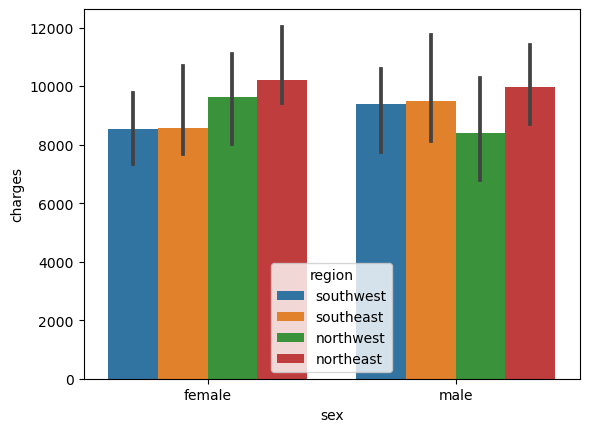

In [63]:
sns.barplot(x='sex', y='charges', hue='region', estimator= np.median, data=pd_df)

This graph clearly demonstrates that in the north of the US, women pay more than men, and in the south, men pay more than women. What's going on here?

The following section explores this a little more, and considers the median for men and women in these areas, and the percentage difference between them.

In [64]:
# NORTHWEST
mask_nw_female = (pd_df["region"] == "northwest") & (pd_df["sex"] == "female")
mask_nw_male = (pd_df["region"] == "northwest") & (pd_df["sex"] == "male")

nw_female_median = np.median(pd_df.loc[mask_nw_female]["charges"]).round(2)
nw_male_median = np.median(pd_df.loc[mask_nw_male]["charges"]).round(2)

print("In the NW, the female median is $" + str(nw_female_median), ", the male median is $" + str(nw_male_median) + 
      " , and so the women are paying more than the men by $" + str((nw_female_median - nw_male_median).round(2)) + 
      " - that is " + str(((nw_female_median - nw_male_median)/nw_male_median*100).round(1)) + "% more")



# NORTHEAST

mask_ne_female = (pd_df["region"] == "northeast") & (pd_df["sex"] == "female")
mask_ne_male = (pd_df["region"] == "northeast") & (pd_df["sex"] == "male")

ne_female_median = np.median(pd_df.loc[mask_ne_female]["charges"]).round(2)
ne_male_median = np.median(pd_df.loc[mask_ne_male]["charges"]).round(2)

print("\nIn the NE, the female median is $" + str(ne_female_median), ", the male median is $" + str(ne_male_median) + 
      " , and so the women are paying more than the men by $" + str((ne_female_median - ne_male_median).round(2)) + 
      " - that is " + str(((ne_female_median - ne_male_median)/ne_male_median*100).round(1)) + "% more")


In the NW, the female median is $9614.07 , the male median is $8413.46 , and so the women are paying more than the men by $1200.61 - that is 14.3% more

In the NE, the female median is $10197.77 , the male median is $9957.72 , and so the women are paying more than the men by $240.05 - that is 2.4% more


So - again - what's going on here?  Why are women paying 14% in the NW, and only 2% more in the NE?  The former seems statistically significant, the second perhaps less so.

It's worth exploring the relationship between the number of children and insurance cost.  If there is a relationship, is it true to say that women in the North West are more likely to have more children, which might contribute to higher costs?  Or is this not a factor at all?

Indeed, do men and women claim to have the same number of children?  Whilst this question may seem trivial, and even amusing, within may lie some important questions about the nature of the data gathering.

In [65]:
nw_female_num_of_children_mean = np.mean(pd_df.loc[mask_nw_female]["children"]).round(2)
nw_male_num_of_children_mean = np.mean(pd_df.loc[mask_nw_male]["children"]).round(2)

print("Reported female mean number of children in the NW: " + str(nw_female_num_of_children_mean))
print("Reported male mean number of children in the NW: " + str(nw_male_num_of_children_mean))

Reported female mean number of children in the NW: 1.12
Reported male mean number of children in the NW: 1.18


The answer is not really. Whilst men do claim on average to have 3.5% more children than women, this seems unlikely to have a bearing on the overall issue.

The image above is from https://www.census.gov/library/visualizations/2021/geo/population-distribution-2020.html. Each white dot is 1000 people, and clearly shows the clustering in the East of the US. This should in thepry have a bearing on medical insurance costs in the East - they should be cheaper in that, generally, cities are cheaper than remote rural areas (source: https://www.expatriatehealthcare.com/the-cost-of-health-insurance-in-the-usa/)

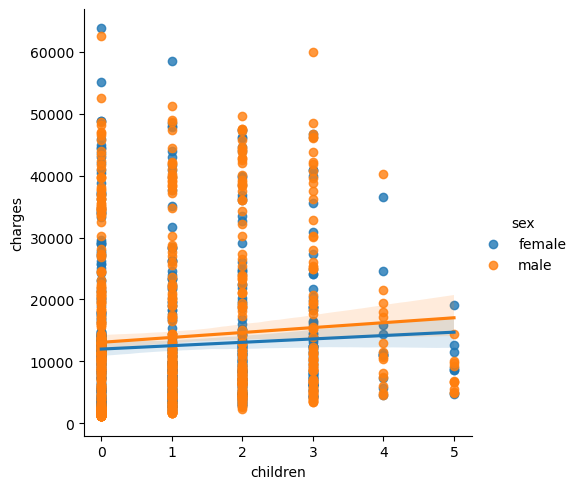

In [66]:
sns.lmplot(x = "children", y = "charges", hue = "sex", data = pd_df)

AttributeError: 'numpy.int64' object has no attribute 'startswith'

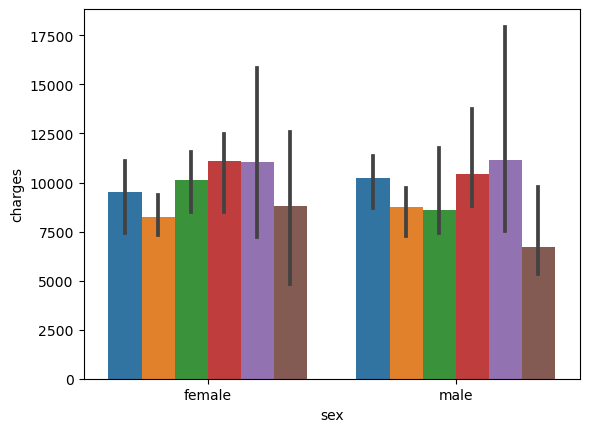

In [67]:
sns.barplot(x='sex', y='charges', hue='children', estimator= np.median, data=pd_df)

In [ ]:
pd_df.groupby(["region", "sex"])["bmi"].median() # Average cost split by biological sex in area